# Predicting Victory Against 2022's Hardest Gaming Boss

### Taking a look into a dataset consisting of death's to Elden Ring's hardest boss: Malenia, Blade of Miquella
##### Mateo Pesa

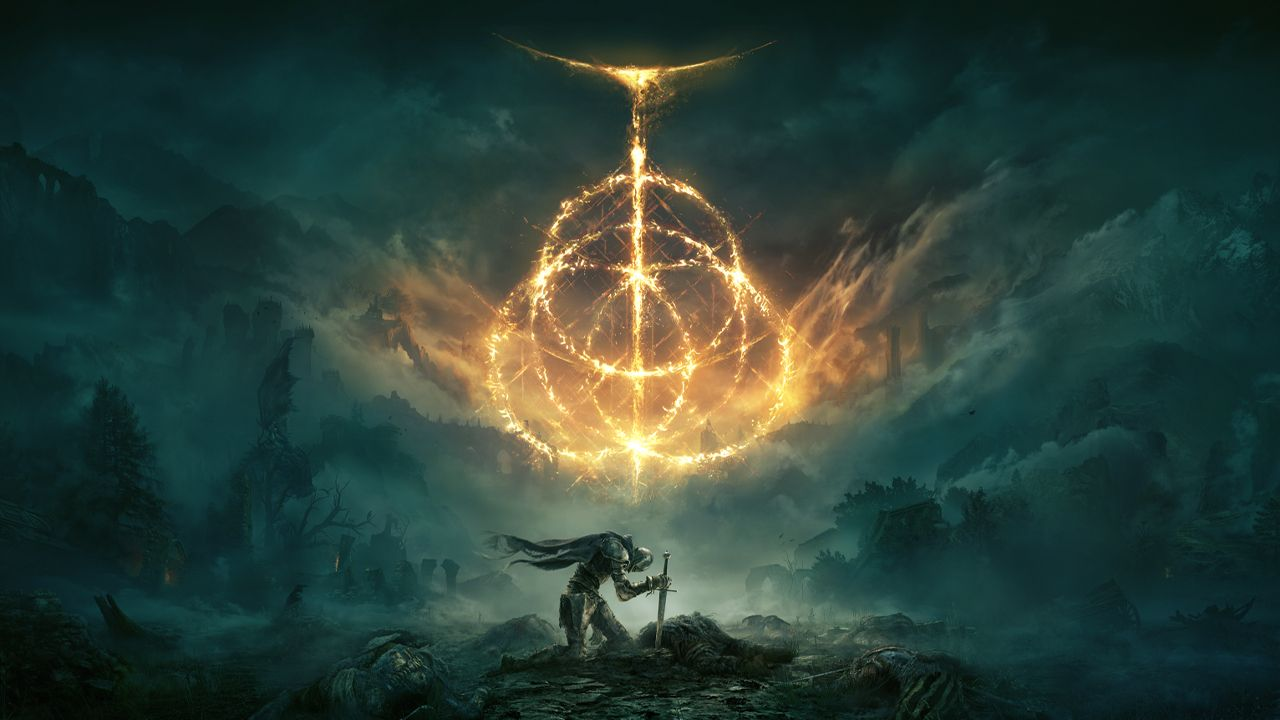

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Introduction](#intro)
2. [First Looks at our Data](#firstlooks)
3. [Exploratory Data Analysis](#eda)
4. [Building Machine Learning Models](#bml)
5. [Conclusions](#conc)

## Introduction  <a class="anchor" id="intro"></a>

Elden Ring is a massive 2022 action role-playing game developed by FromSoftware and published by Bandai Namco Entertainment. Directed by Hidetaka Miyazaki with worldbuilding provided by fantasy writer George R. R. Martin, it was released for PlayStation 4, PlayStation 5, Windows, Xbox One, and Xbox Series X/S on February 25. In the game, players control a customizable player character on a journey to repair the titular Elden Ring and become the new Elden Lord. Towards the end of the game, players are able to face Malenia, Blade of Miquella. She is widely regarded as the hardest boss in ALL of FromSoftware's videogames. Naturally, I decided to predict whether or not a player would be able to defeat Malenia when given information about their characters.

The following project will attempt to predict and understand what factors of a player's build and gameplay will lead to victories or losses against Malenia. I will utilize machine learning techniques and models learned throughout the duration of INFO 1998. 

By visualizing data, predicting trends, applying models, and extrapolating and interpolating data points, we can hopefully can an insightful understanding of what factors most directly allow for a victory. This can hopefully guide new players who may be stuck on the boss, allowing them to maximize their likelihood of winning

__Sources__

The following CSV dataset was obtained under the CC 4.0 free and public use license, as hosted by Kaggle.com and its publishers.

The dataset can be found here: https://www.kaggle.com/datasets/jordancarlen/host-deaths-to-malenia-blade-of-miquella

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
sns.set(rc = {'figure.figsize':(15,8)})

## First Looks at our Data <a class="anchor" id="firstlooks"></a>

__We see the following variables:__

1. Host_Death_Time: The time, in seconds, that the host was beaten by Malenia. This only applies to our losses
2. Host_Build: The type of build that the host was using. We have 5 options:
    1. Raw_Melee: A build based on dealing normal damage with a melee weapon
    2. Proc_Melee: A build based on dealing status effect damage with a melee weapon
    3. Raw_Cast: A build based on dealing normal damage with sorceries/incantations from a distance
    4. Proc_Cast: A build based on dealing status effect damage with sorceries/incantations from a distance
    5. Hybrid: A mix of any of the 4 builds that we have already covered, such as Proc_Melee/Proc_Cast
3. Level: The level of the host
5. Health_Pct: The percentage of Malenia's health left at the time of the host's death. This will be used later for feature engineering
6. Location: The arena is split into three different sectors, outer, inner, and center. Outer corresponds to the edges of the arena, inner the middle area, and center the direct middle of the arena.
7. Phantom_Count: In Elden Ring, you are able to summon other players to your game to assist with difficult bosses. This is the number of people that the original host summoned. This is 1 by default as the data was collected BY a phantom.
8. Phantom_Build: This follows the same logic as Host_Build, except it follows the Summoned player's build. The possibilities are the same, with NaN
9. Phantom_Death: This is a boolean variable telling us whether the summoned character died before the host did.

In [2]:
malenia = pd.read_csv('/Users/mateopesa/INFO1998/FinalProject/malenia.csv')
malenia=malenia.drop('Phase', axis=1)
malenia=malenia.drop('Host_Death_Time', axis=1)
malenia=malenia.drop('Waterflow_Death', axis=1)
malenia.head()

,Host_Build,Level,Health_Pct,Location,Phantom_Count,Phantom_Build,Phantom_Death
0,RAW_MELEE,124.0,66.0,INNER,2.0,RAW_MELEE,True
1,HYBRID,169.0,92.0,CENTER,2.0,PROC_CAST,True
2,PROC_MELEE,179.0,93.0,INNER,1.0,NaN,NaN
3,RAW_CAST,141.0,89.0,INNER,2.0,RAW_MELEE,False
4,PROC_CAST,126.0,64.0,INNER,2.0,PROC_MELEE,True


We have a small issue being that we do not have access to data in which Melania was succesfully beaten. To counterract this, we will use our Health_Pct to create a new variable called "Likely_Beaten" where we will assign values of 0 or 1 based on the percentage of health left. This will not create much bias as towards the end of the game, players are able to deal thousands of health points with just one hit. We can attribute the last bit of health to a player-based mistake.

In [3]:
#Creating the column
malenia_engineered= malenia.copy()
malenia_engineered['Likely_Beaten']=0
for x in range(0,len(malenia)):
    if malenia_engineered['Health_Pct'][x]<9:
        malenia_engineered['Likely_Beaten'][x]=1

#Drop Health_Pct as we no longer need it
malenia_engineered= malenia_engineered.drop("Health_Pct", axis=1)

<ipython-input-3-4d732fc47d77>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malenia_engineered['Likely_Beaten'][x]=1


In [4]:
#Splitting our data into winners and losers to allow us to analyze the data seperately
winners = malenia_engineered.loc[malenia_engineered['Likely_Beaten'] == 1]
losers= malenia_engineered.loc[malenia_engineered['Likely_Beaten']==0]

## Exploratory Data Analysis <a class="anchor" id="eda"></a>
__Analyzing Host_Build__

<AxesSubplot:xlabel='Host_Build', ylabel='Count'>

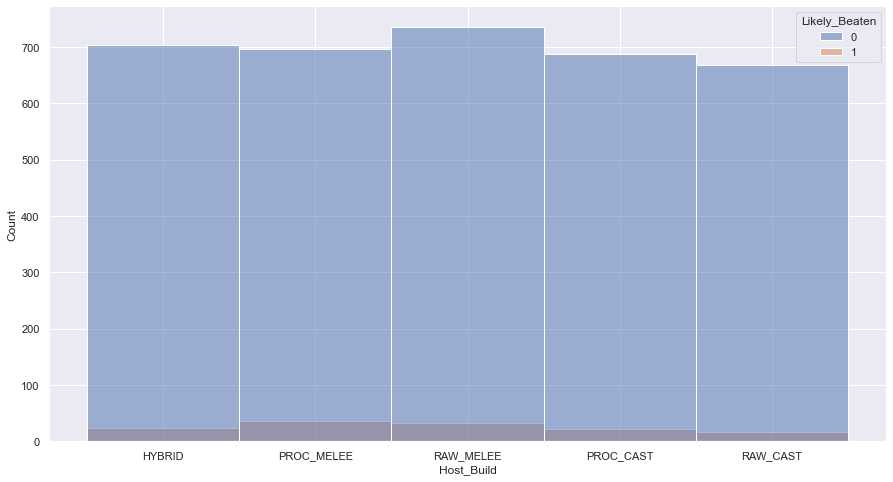

In [5]:
#Combine our winners and losers for a full dataset
malenia_full=pd.concat([winners, losers], axis=0)

#Plot build counts
sns.histplot(data=malenia_full, x="Host_Build", hue="Likely_Beaten")

It will be hard to draw meaningful conclusions due to the scale differences in our data. Lets take a random sample from losers to allow us better visual analysis of the data.

<AxesSubplot:xlabel='Host_Build', ylabel='Count'>

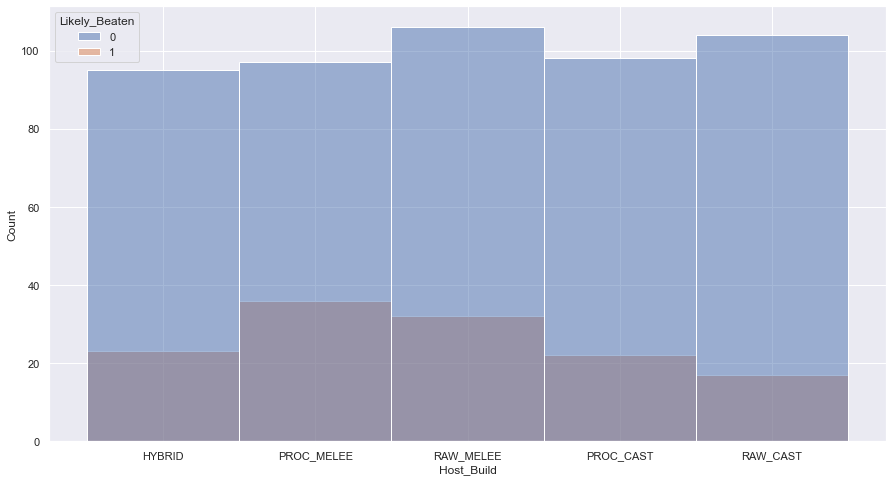

In [6]:
#Select a group of losers to allow us to analyze the data visually due to scaling issues
selected_losers=losers.sample(n=500,random_state=23)

#Create a reduced model that consists of both winners and selected losers.
malenia_reduced=pd.concat([winners, selected_losers], axis=0)
sns.histplot(data=malenia_reduced, x="Host_Build", hue="Likely_Beaten")

We see that losing players are most commonly using hybrid builds and raw cast builds, while winners are most commonly using melee builds focused on procs. This will factor into the classification model, as those who are using hybrid/casting builds may be ill-fit for the boss battle. How does this compare to the overall count of each build? Let's see.

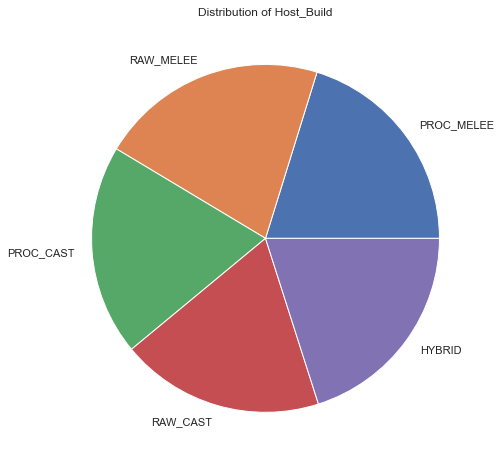

In [7]:
#Create a pie chart of whether they are a smoker and if they lived or not
melee_proc = malenia[malenia['Host_Build']=='PROC_MELEE']
melee_raw = malenia[malenia['Host_Build']=='RAW_MELEE']
cast_proc = malenia[malenia['Host_Build']=='PROC_CAST']
cast_raw = malenia[malenia['Host_Build']=='RAW_CAST']
hybrid= malenia[malenia['Host_Build']=='HYBRID']

values = [len(melee_proc), len(melee_raw), len(cast_proc), len(cast_raw), len(hybrid)]
labels = ['PROC_MELEE', 'RAW_MELEE', 'PROC_CAST', 'RAW_CAST', 'HYBRID']

# create the pie chart
plt.pie(values, labels=labels)

# add a title
plt.title('Distribution of Host_Build')

# show the chart
plt.show()

Seeing as all of our builds seem to be around the same count, we are able to assume that certain builds may contribute to a win/loss as our winner/loser histograms show certain builds having larger counts.

__Analyzing Level__

<AxesSubplot:xlabel='Level', ylabel='Count'>

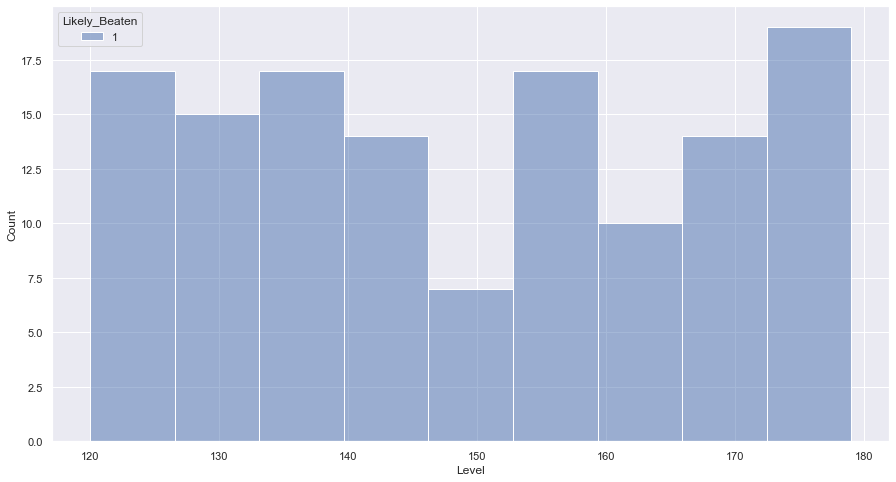

In [8]:
sns.histplot(data=winners, x="Level", hue="Likely_Beaten")

We see that winners tend to be at the extreme values of our levels, with a decrease around 150. Now let's compare this to the losers

<AxesSubplot:xlabel='Level', ylabel='Count'>

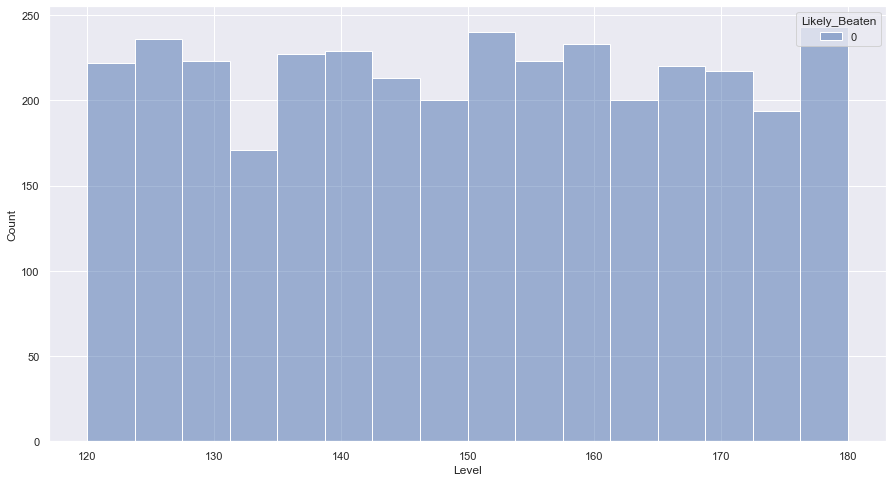

In [9]:
sns.histplot(data=losers, x="Level", hue="Likely_Beaten")

We see that losers have a relatively uniform distribution when analyzing the level. There isn't much statistical significance here.

__Analyzing Phantom_Build and Phantom_Count__

Of our winners, how many of them had more than one phantom?

<AxesSubplot:xlabel='Phantom_Count', ylabel='Count'>

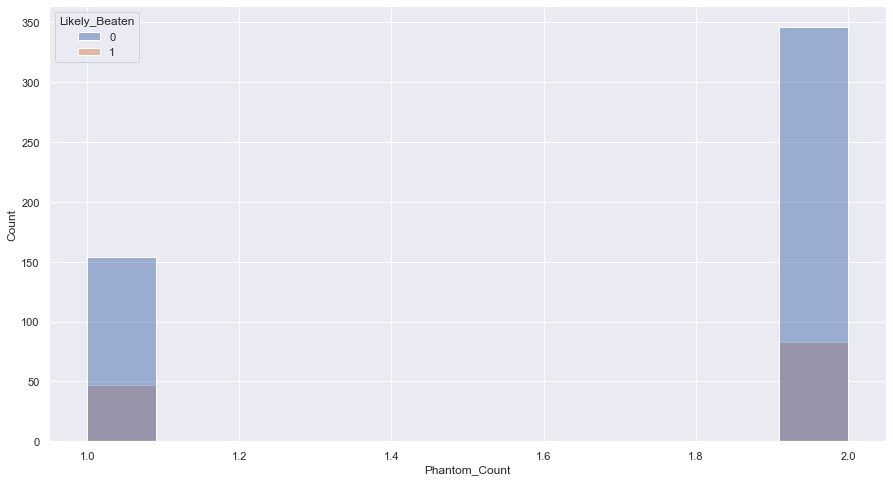

In [10]:
sns.histplot(data=malenia_reduced, x="Phantom_Count", hue='Likely_Beaten')

It was more common for our winners to have an extra phantom helping out, however there is the same pattern within the losers.

How does Phantom_Build effect our win count?

<AxesSubplot:xlabel='Phantom_Build', ylabel='Count'>

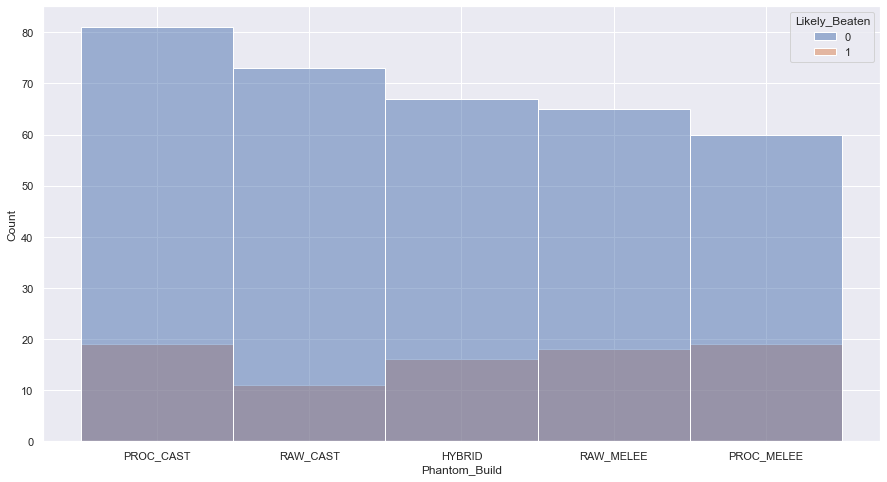

In [11]:
sns.histplot(data=malenia_reduced.dropna(), x="Phantom_Build", hue="Likely_Beaten")

Similar to our Host_Build pattern, it seems as thought Raw casters are the least equipped for this fight. This differs from host_builds in the fact that Proc_Cast is the leading winner, while Proc_Melee was the leading winner for Host_Build

__Analyzing the Correlation Between our Variables. Which are going to be useful in prediction?__

Lets use a heatmap to see which variables are most influential in predicting wins and losses against Malenia

In [12]:
#Making Dummy Variables
cat_cols = ['Host_Build','Location','Phantom_Build', 'Phantom_Death']
malenia_full_with_dummies = pd.get_dummies(malenia_full,columns=cat_cols)
malenia_full_with_dummies= malenia_full_with_dummies.dropna()

malenia_reduced_with_dummies=pd.get_dummies(malenia_reduced, columns=cat_cols)
malenia_reduced_with_dummies=malenia_reduced_with_dummies.dropna()

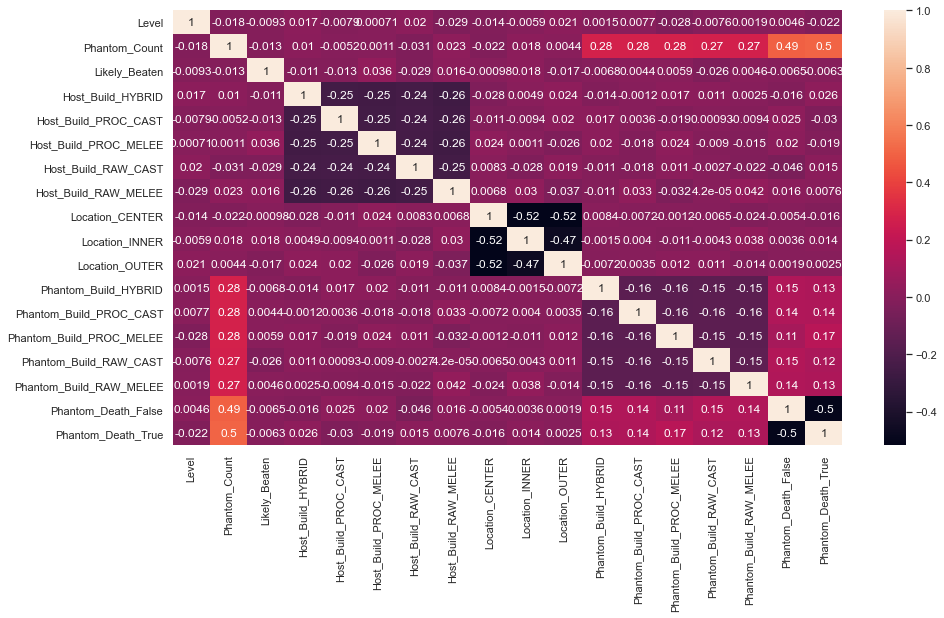

In [13]:
#Making heatmaps
corr = malenia_full_with_dummies.corr()
sns.heatmap(corr, annot=True)
plt.show()

This pattern is quite interesting. We see that many of our variables have small correlations with Likely_Beaten. This is likely due to the fact that our winners are greatly outnumbered by our losers. How will this change for a heatmap of the reduced model?

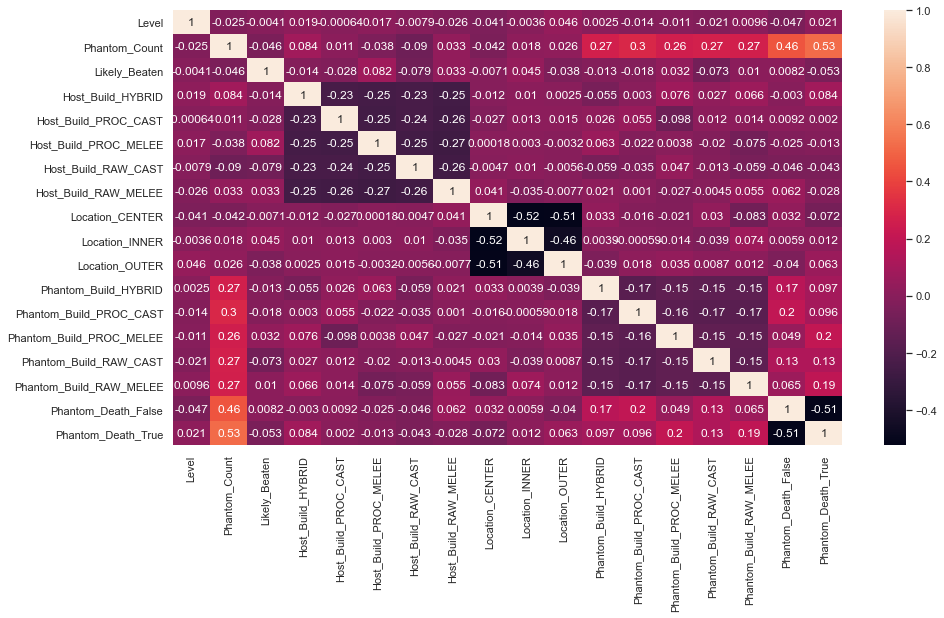

In [14]:
corr = malenia_reduced_with_dummies.corr()
sns.heatmap(corr, annot=True)
plt.show()

We now see much larger correlations between our predictors and our response, with a host build of proc_melee and a phantom build of raw_cast being the highest in magnitude.

Although there are clearer patterns, this sample may not represent our dataset. Lets use imblearn to oversample the minority (winners) in our dataset and compare the correlations then.

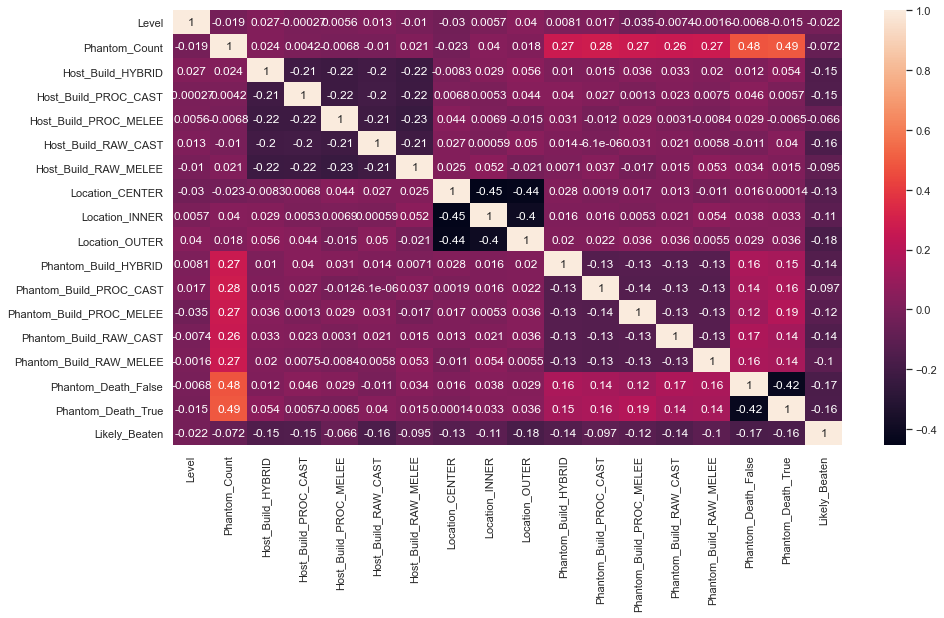

In [15]:
#Get our feature and target variables
X = malenia_full_with_dummies.drop('Likely_Beaten', axis=1)
y = malenia_full_with_dummies['Likely_Beaten']

sm = SMOTE(random_state=24, sampling_strategy= 0.25)

# Use SMOTE to oversample the winners
X_resampled, y_resampled = sm.fit_resample(X, y)
resampled_dataset= X_resampled.copy()
resampled_dataset['Likely_Beaten']=y_resampled


corr = resampled_dataset.corr()
sns.heatmap(corr, annot=True)
plt.show()

By resampling our data, we are able to see trends in our data to a much greater extent. The correlation of almost every indicator increased, allowing us to draw more meaningful conclusions with this model. Our most impactful variables are Hybrid and Casting builds for the host, all 3 locations, and our phantom builds.

## Building Machine Learning Models <a class="anchor" id="bml"></a>

I will be comparing the full dataset's performance in a Logistic Regression compared to a Random Forest Classification.

### Logistic Regresion:

__Logistic Regression for the Full Model__

In [16]:
X = malenia_full_with_dummies.drop('Likely_Beaten', axis=1)
y = malenia_full_with_dummies['Likely_Beaten']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

# predict on the test set
pred_test= logistic.predict(X_test)
pred_train = logistic.predict(X_train)

# evaluate the model performance
print("Test Accuracy: ", accuracy_score(y_test, pred_test))
print("Training Accuracy: ", accuracy_score(y_train, pred_train))

Test Accuracy:  0.9586206896551724
Training Accuracy:  0.9654696132596685


/Users/mateopesa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


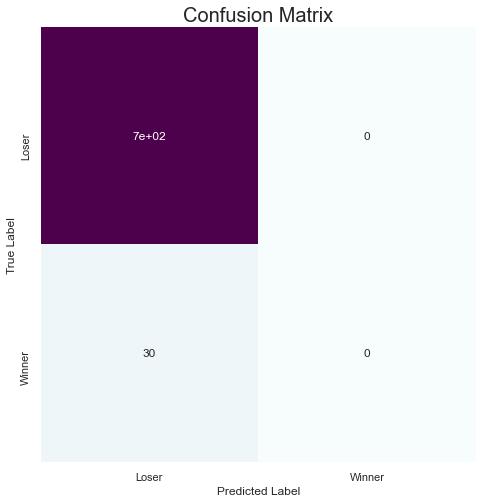

In [17]:
#confusion matrix
plt.figure()
con_matrix = confusion_matrix(y_test, logistic.predict(X_test))
sns.heatmap(con_matrix, cmap='BuPu', annot=True, cbar=False, square=True, xticklabels=['Loser', 'Winner'], yticklabels=['Loser', 'Winner'] )



plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

Although we have high testing and training accuracies of 0.96 and 0.97 respectively, this is not a very effective model due to the difference in scale. Rather than predicting winners, it is just throwing all observations into the loser category and relying on the size of the dataset to increase accuracy. Let's use our resampled data to find clearer patterns.

__Logistic Regression with Resampled Data__

In [18]:
#Get our feature and target variables
X = malenia_full_with_dummies.drop('Likely_Beaten', axis=1)
y = malenia_full_with_dummies['Likely_Beaten']

sm = SMOTE(random_state=24, sampling_strategy= 0.25)

# Use SMOTE to oversample the winners
X_resampled, y_resampled = sm.fit_resample(X, y)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

# predict on the test set
pred_test= logistic.predict(X_test)
pred_train = logistic.predict(X_train)

# evaluate the model performance
print("Test Accuracy: ", accuracy_score(y_test, pred_test))
print("Training Accuracy: ", accuracy_score(y_train, pred_train))

Test Accuracy:  0.9541809851088202
Training Accuracy:  0.9578796561604584


/Users/mateopesa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


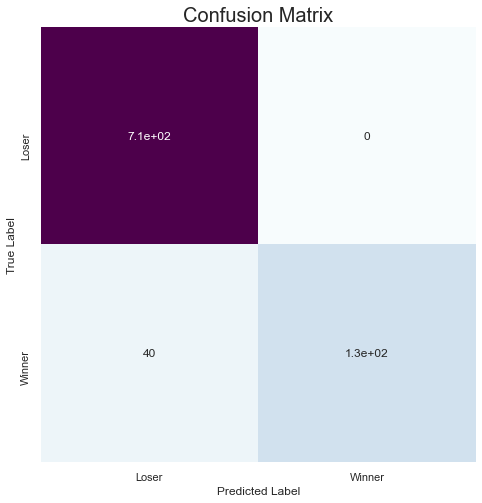

In [19]:
#confusion matrix
plt.figure()
con_matrix = confusion_matrix(y_test, logistic.predict(X_test))
sns.heatmap(con_matrix, cmap='BuPu', annot=True, cbar=False, square=True, xticklabels=['Loser', 'Winner'], yticklabels=['Loser', 'Winner'] )



plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

This is much better. Our accuracies are still high with a test and training accuracy of 0.96 for both. We have 690 correctly predicted losers, 140 correctly predicted winners, and 43 predicted losers who were actually winners

### Random Forest Classification

__Random Forest Classification for our Full model__

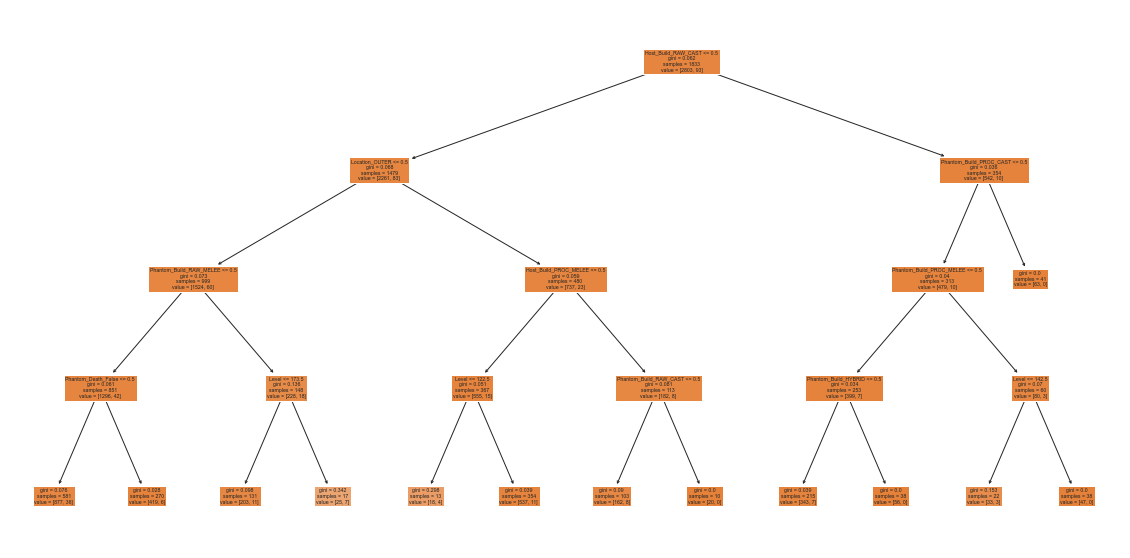

Test Accuracy:  0.9586206896551724
Training Accuracy:  0.9654696132596685


In [20]:
#Get our feature and target variables
X = malenia_full_with_dummies.drop('Likely_Beaten', axis=1)
y = malenia_full_with_dummies['Likely_Beaten']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Train a machine learning model on the resampled data
rfc = RandomForestClassifier(max_depth = 4)
rfc.fit(X_train, y_train)

# Evaluate the model on the test set
pred_test = rfc.predict(X_test)
pred_train=rfc.predict(X_train)

plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[0], filled=True, feature_names=X_train.columns)
plt.show()

print("Test Accuracy: ", accuracy_score(y_test, pred_test))
print("Training Accuracy: ", accuracy_score(y_train, pred_train))

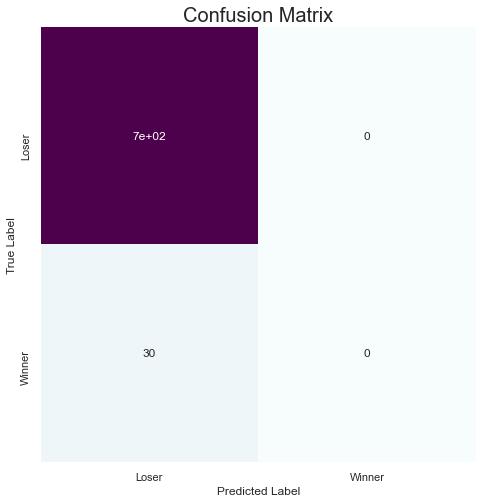

In [21]:
plt.figure()
con_matrix = confusion_matrix(y_test, rfc.predict(X_test))
sns.heatmap(con_matrix, cmap='BuPu', annot=True, cbar=False, square=True, xticklabels=['Loser', 'Winner'], yticklabels=['Loser', 'Winner'] )



plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

We see high accuracies for both testing and training, however we have the same problem that we had for logistic regression. There are far too many losers, and not enough winners. Lets resample again.

__Random Forest Classification for our Oversampled Model__

In [22]:
#Get our feature and target variables
X = malenia_full_with_dummies.drop('Likely_Beaten', axis=1)
y = malenia_full_with_dummies['Likely_Beaten']

sm = SMOTE(random_state=24, sampling_strategy= 0.25)

# Use SMOTE to oversample the winners
X_resampled, y_resampled = sm.fit_resample(X, y)


#Use the same train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a machine learning model on the resampled data
rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_train, y_train)

# Evaluate the model on the test set
pred_test = rfc.predict(X_test)
pred_train=rfc.predict(X_train)

print("Test Accuracy: ", accuracy_score(y_test, pred_test))
print("Training Accuracy: ", accuracy_score(y_train, pred_train))

Test Accuracy:  0.854524627720504
Training Accuracy:  0.8601719197707737


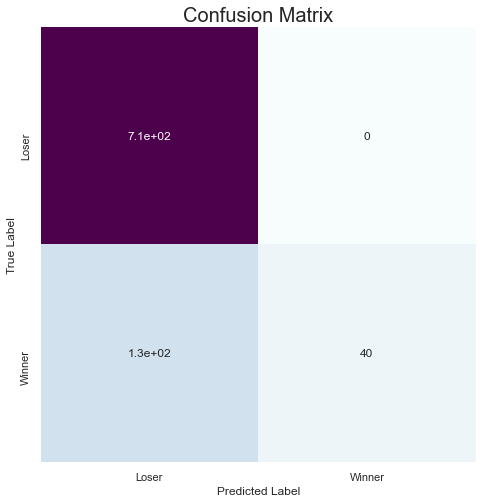

In [23]:
plt.figure()
con_matrix = confusion_matrix(y_test, rfc.predict(X_test))
sns.heatmap(con_matrix, cmap='BuPu', annot=True, cbar=False, square=True, xticklabels=['Loser', 'Winner'], yticklabels=['Loser', 'Winner'] )



plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

Not only do we have lower accuracies at 0.84 and 0.85 with a Random Forest Classifier for our resampled model, we only have 30 correctly classified winners.

### Model Selection

__Logistic Regression vs. RandomForestClassifier?__

For my dataset, it seems as if Logistic Regression is better fit to predict victories against Malenia due to higher accuracies and a better spread of True Positives and True Negatives when using the resampled data. 


## Conclusions <a class="anchor" id="conc"></a>

- After comparing different models that were modelled on different datasets, we conclude that Logistic Regression produced the best results, especially when using the Resampled Data.

- It is clear that our resampled data allowed for better analyses all around between correlation analysis, training accuracy, and testing accuracy.
    - Certain variables were unexpectedly insignificant, such as player level. I expected that to have much more effect than it did.

- In the future, I would like to collect data from actual victories in Elden Ring against Malenia to allow for less feature engineering and more accurate analyses, however using SMOTE allowed for much better analysis than reducing the model entirely as seen in our data visualization section.

